### 百度指数获取
#### 郑宇浩 41621101
#### 该文件主要对应于论文中的注释[7]和[8]，实现百度指数时序的构建与8个金融词汇的时差相关系数与特征重要性的求算

In [1]:
import pandas as pd
import tushare as ts
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import os
path=os.path.abspath('.')

#### 1. 数据导入：请务必先将所需文件Upload到jupyter中，文件位于与该notebook同目录下的文件夹，文件名为百度指数.xlsx

In [2]:
index_ts=pd.read_excel(path+"\百度指数.xlsx",index_col=0)
index_word=index_ts.columns # 得到八个金融词汇2014年3月3日至2016年2月29日的百度搜索指数时间序列
stock_300=list(reversed(list(ts.get_hist_data("hs300",'2014-03-03','2016-02-29','W')['close']))) # 得到对应时间下的沪深300指数周收盘价

#### 2. 数据处理：对百度指数时序进行周期为4的移动平均

In [3]:
for i in index_word:
    new_name=" "+i
    index_ts[new_name]=index_ts[i].rolling(window=4).mean()

index_word_mavg=index_ts.columns[8:]

#### 3. 求算时差相关系数：算法请参考论文中的公式(1)

In [4]:
n=len(index_word_mavg)
ahead_corr={}
for i in index_word_mavg:
    corr=0
    ahead=0
    for j in range(1,10,1):
        matrix=np.array([stock_300[3+j:],index_ts[i][3:-j]])
        if(abs(np.corrcoef(matrix)[0,1])>abs(corr)):
            corr=np.corrcoef(matrix)[0,1]
            ahead=j
    ahead_corr[i]=[corr,ahead]
sort=sorted(ahead_corr.items(),key=lambda x:x[1],reverse=True)
new_ahead_corr={}
for i in range(n):
    new_ahead_corr[sort[i][0]]=sort[i][1]

In [5]:
new_ahead_corr # [时差相关系数，提前期]

{' 股票代码': [0.8160103704293675, 1],
 ' 股票交易': [0.7866945083259231, 1],
 ' 股票市场': [0.7522953167421741, 1],
 ' 股价': [0.6510626213328183, 1],
 ' 股票行情': [0.6239632670793692, 1],
 ' 行情': [0.512280597908519, 1],
 ' 股市': [0.4204174560979708, 1],
 ' 交易': [0.26713189004711274, 5]}

#### 4. 利用随机森林求算特征重要性

In [6]:
n=len(index_ts.index)
m=len(index_word_mavg)
data=np.zeros(shape=(n-4,m))
for i in range(4,n,1):
    for j in range(m):
        increase=(index_ts[index_word_mavg[j]][i]-index_ts[index_word_mavg[j]][i-1])/index_ts[index_word_mavg[j]][i-1]
        data[i-4][j]=increase

# 将沪深300指数的周收盘价波动率大小作为类别变量，分类标准见表2

target=np.zeros(n-1)
for i in range(1,n,1):
    increase=(stock_300[i]-stock_300[i-1])/stock_300[i-1]
    if(increase<=0.02 and increase>=-0.02):
        target[i-1]=0
    elif(increase>0):
        if(increase<=0.06):
            target[i-1]=1
        else:
            target[i-1]=2
    else:
        if(increase>=-0.06):
            target[i-1]=-1
        else:
            target[i-1]=-2

In [7]:
# 将8个金融词汇的百度搜索指数波动率作为特征输入随机森林分类器

score={}
forest=RandomForestClassifier(n_estimators=10000,random_state=0,n_jobs=1)
forest.fit(data,target[3:])
importance=forest.feature_importances_
index_word_mavg=index_word_mavg[importance.argsort()]
importance.sort()
for i in range(m):
    score[index_word_mavg[m-1-i]]=importance[m-1-i]

In [8]:
score

{' 股票市场': 0.1559357451493813,
 ' 股票代码': 0.14371916030351634,
 ' 股票交易': 0.13595757102654443,
 ' 交易': 0.12042137004781718,
 ' 股市': 0.11843952630791946,
 ' 股票行情': 0.11190796061257723,
 ' 股价': 0.10794838685804914,
 ' 行情': 0.10567027969419428}

#### 5. 数据可视化

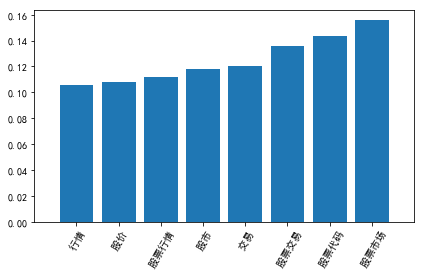

In [9]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.bar(range(m),importance,align='center')
plt.xticks(range(m),index_word_mavg,rotation=60)
plt.xlim([-1,m])
plt.tight_layout()
plt.show()